# Predicting Tennis Tournament Levels from Player Stats

## Introduction
The ATP is a tennis organization that organizes and runs various tennis tournaments. Each tournament is categorized in the following way:
- G: Grand slams
- M: Master 1000s
- D: Davis cup
- F: tour finals + other ending events
- A: other events

We wish to determine if there is a connection between the tournament level and the statistics of the game and players. This leads us to the question: 

> Can we predict the level of a tennis tournament from game length and the players’ ages and heights?

The dataset contains the game results and player information for the Top 500 players from 2017-2019.  It contains stats from both the winner and loser of a match at a tournament level. It was compiled [here](https://github.com/JeffSackmann/tennis_atp) by Jeff Sackmann.

### Distribution of tournament levels problem

In our preliminary analysis, we found that the distribution of tournament levels in our dataset was not equal. We saw that the D and F tournament levels had many orders of magnitude fewer observations than others, and G and M tournament levels had noticeably fewer observations than A. We had three possible solutions to this:


1) Upsample our entire dataset to match the number of observations of A,  
2) Drop D and F and upsample the remaining dataset to match A,  
3) Drop D and F and do **not** upsample the dataset.  

After experimenting with the performance of the model for each of these possible solutions, we decided to choose solution 3. Upsampling the entire dataset was never a feasible option, as our training dataset only contained 56 D and 15 F observations, so to upsample this to around 1000 would be meaningless. Dropping (D)avis Cup & (F) tour finals + other ending events from our data set results in a higher accuracy, since attempting to fit our model with so few of these observations would only result in our model performing worse overall, and by narrowing our approach, we can have a more successful and useful model. 

From here, we had the option of upsampling the data with the remaining tournament levels (G, M & A). We found that, since we were effectively doubling the number of G and M observations with zeroed data, the accuracy dropped substantially for all values of K. For completeness sake, the upsampled tuning results are shown alongside the non-upsampled ones in the **Method** analysis below. Since we wanted a model that performed as best as possible, we decided to choose solution \#3, as it gave us the highest accuracy.

### The Model Outline

This is a classification problem, where we will use the K-nearest neighbors algorithm. To determine the optimal value of K for our model, we will try *15* values of K from 1 to 15, cross-validating with 5 folds. This will give us our K to use for our final model.

Since we only care about the variables which physically describe the players and the game we chose the following variables:
- Tournament level (G, M or A)
- Winner and loser height (centimeters)
- Winner and loser age (years)
- Game length (minutes)

We dropped columns in the dataset which were irrelevant to us, such as the players’ name and country.

The split percentage we chose is 75-25 train-test. This is because we want as much of the dataset to be used to train the model as possible, since the test dataset is only used to calculate the accuracy of the model. A higher percentage in the train dataset (within reason) results in the model having more data to fit on, increasing the accuracy.

If we count the number of empty values in our dataset (NAs), we find that there are 2196 in the winner height column, 2718 in the loser height column and 116 in the minutes column. Since we are using these columns to predict the tournament level, these rows with missing values contribute nothing and can be dropped from the dataset. 

## Visualizing the dataset

In [17]:
library(tidyverse)
library(repr)
library(tidymodels)

In [3]:
# Load data (csv format) from URL
tennis_raw_data = read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [36]:
# Count number of NAs
tennis_raw_data %>% 
    select(tourney_level, winner_ht, loser_ht, winner_age, loser_age, minutes) %>% 
    summarise_all(funs(sum(is.na(.))))

tourney_level,winner_ht,loser_ht,winner_age,loser_age,minutes
<int>,<int>,<int>,<int>,<int>,<int>
0,2196,2718,0,0,116


In [4]:
# Select columns we plan to use, drop rows with missing data & drop rows with tourney level D or F.
tennis_data <- tennis_raw_data %>% 
    select(tourney_level, winner_ht, loser_ht, winner_age, loser_age, minutes) %>%
    na.omit() %>% 
    filter(tourney_level != "D" & tourney_level != "F") %>%
    mutate(tourney_level = as_factor(tourney_level)) %>%
    mutate(match_length = minutes) %>% 
    select(-minutes)
    
head(tennis_data)

tourney_level,winner_ht,loser_ht,winner_age,loser_age,match_length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,178,188,29.00479,31.88227,66
A,178,188,29.00479,27.62765,100
A,188,193,31.88227,23.67967,99
A,188,183,27.62765,29.54689,88
A,178,180,29.00479,26.37098,79
A,190,183,31.63039,26.94319,88


In [5]:
# Split data into training and testing set

tennis_split <- initial_split(tennis_data, prop = .75, strata = tourney_level)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

In [6]:
# Count the number of rows for each tournament level.
tennis_summary_num <- tennis_train %>%
    group_by(tourney_level) %>%
    summarize(n = n())

# Calculate the mean for all other columns.
#    Prepends 'mean.' to the front of all column names.
tennis_summary <- tennis_train %>% 
    group_by(tourney_level) %>%
    summarize_all(mean) %>% 
    rename_with(~ paste0("mean.", .), .cols = !tourney_level)

# Join summary tables (count + average)
summary_table <- tennis_summary_num %>% 
    inner_join(tennis_summary)

summary_table

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "tourney_level"



tourney_level,n,mean.winner_ht,mean.loser_ht,mean.winner_age,mean.loser_age,mean.match_length
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,1104,186.2246,186.0752,29.63713,30.08444,99.52174
G,446,187.2489,186.5695,29.81963,29.89221,149.92152
M,525,187.5200,186.4229,29.55974,29.62428,101.73524


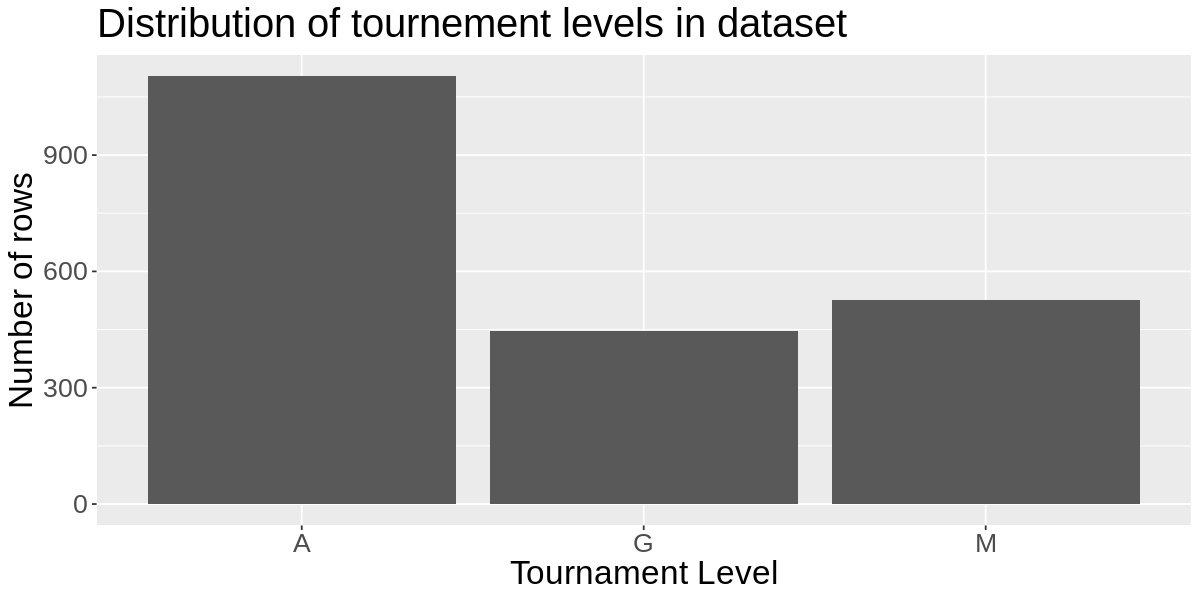

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Plot the number of rows for each tournament level. 
#     Determines if we need to trim data to balance it or not,
#     which we obviously do.

tourney_level_dist <- ggplot(summary_table, aes(x = tourney_level, y = n)) +
    geom_bar(stat = 'identity') +
    theme(text = element_text(size = 20)) +
    labs(x = "Tournament Level",
             y = "Number of rows",
             colour = "Tournament level",
             title = "Distribution of tournement levels in dataset")

tourney_level_dist

In [8]:
# Convert the data from a prediction format into a format that can be easily plotted.
#    Pivots the data to add an extra column called 'player_type' which specifies if the player is a winner or loser.
#    This means that the data can be plotted on a facet_grid nicely without having to do any trickery.

plot_data <- tennis_train %>% 
    mutate(row = row_number()) %>%
    pivot_longer(winner_ht:loser_age, names_to = c("player_type", "category"), names_pattern = "([A-Za-z]+)_([A-Za-z]+)", values_to = "value") %>%
    mutate(category = as_factor(category)) %>% 
    mutate(player_type = as_factor(player_type)) %>% 
    pivot_wider(names_from = category, values_from = value) %>% 
    select(-row)

In [9]:
# Plot the match length vs the player height for both winner and loser and each tournament level. 

tennis_plot_height = plot_data %>%
    ggplot(aes(x = match_length, 
               y = ht, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Height of player (cm)",
         colour = "Tournament level",
         title = "Player height vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

In [10]:
# Plot the match length vs the player age for both winner and loser and each tournament level. 

tennis_plot_age = plot_data %>%
    ggplot(aes(x = match_length, 
               y = age, 
               colour = tourney_level)) +
    geom_point(alpha = 0.5) + 
    labs(x = "Length of game (minutes)",
         y = "Age of player (years)",
         colour = "Tournament level",
         title = "Player age vs length of game for each tournament level") +
    facet_grid(tourney_level ~ player_type) +
    theme(text = element_text(size = 20))

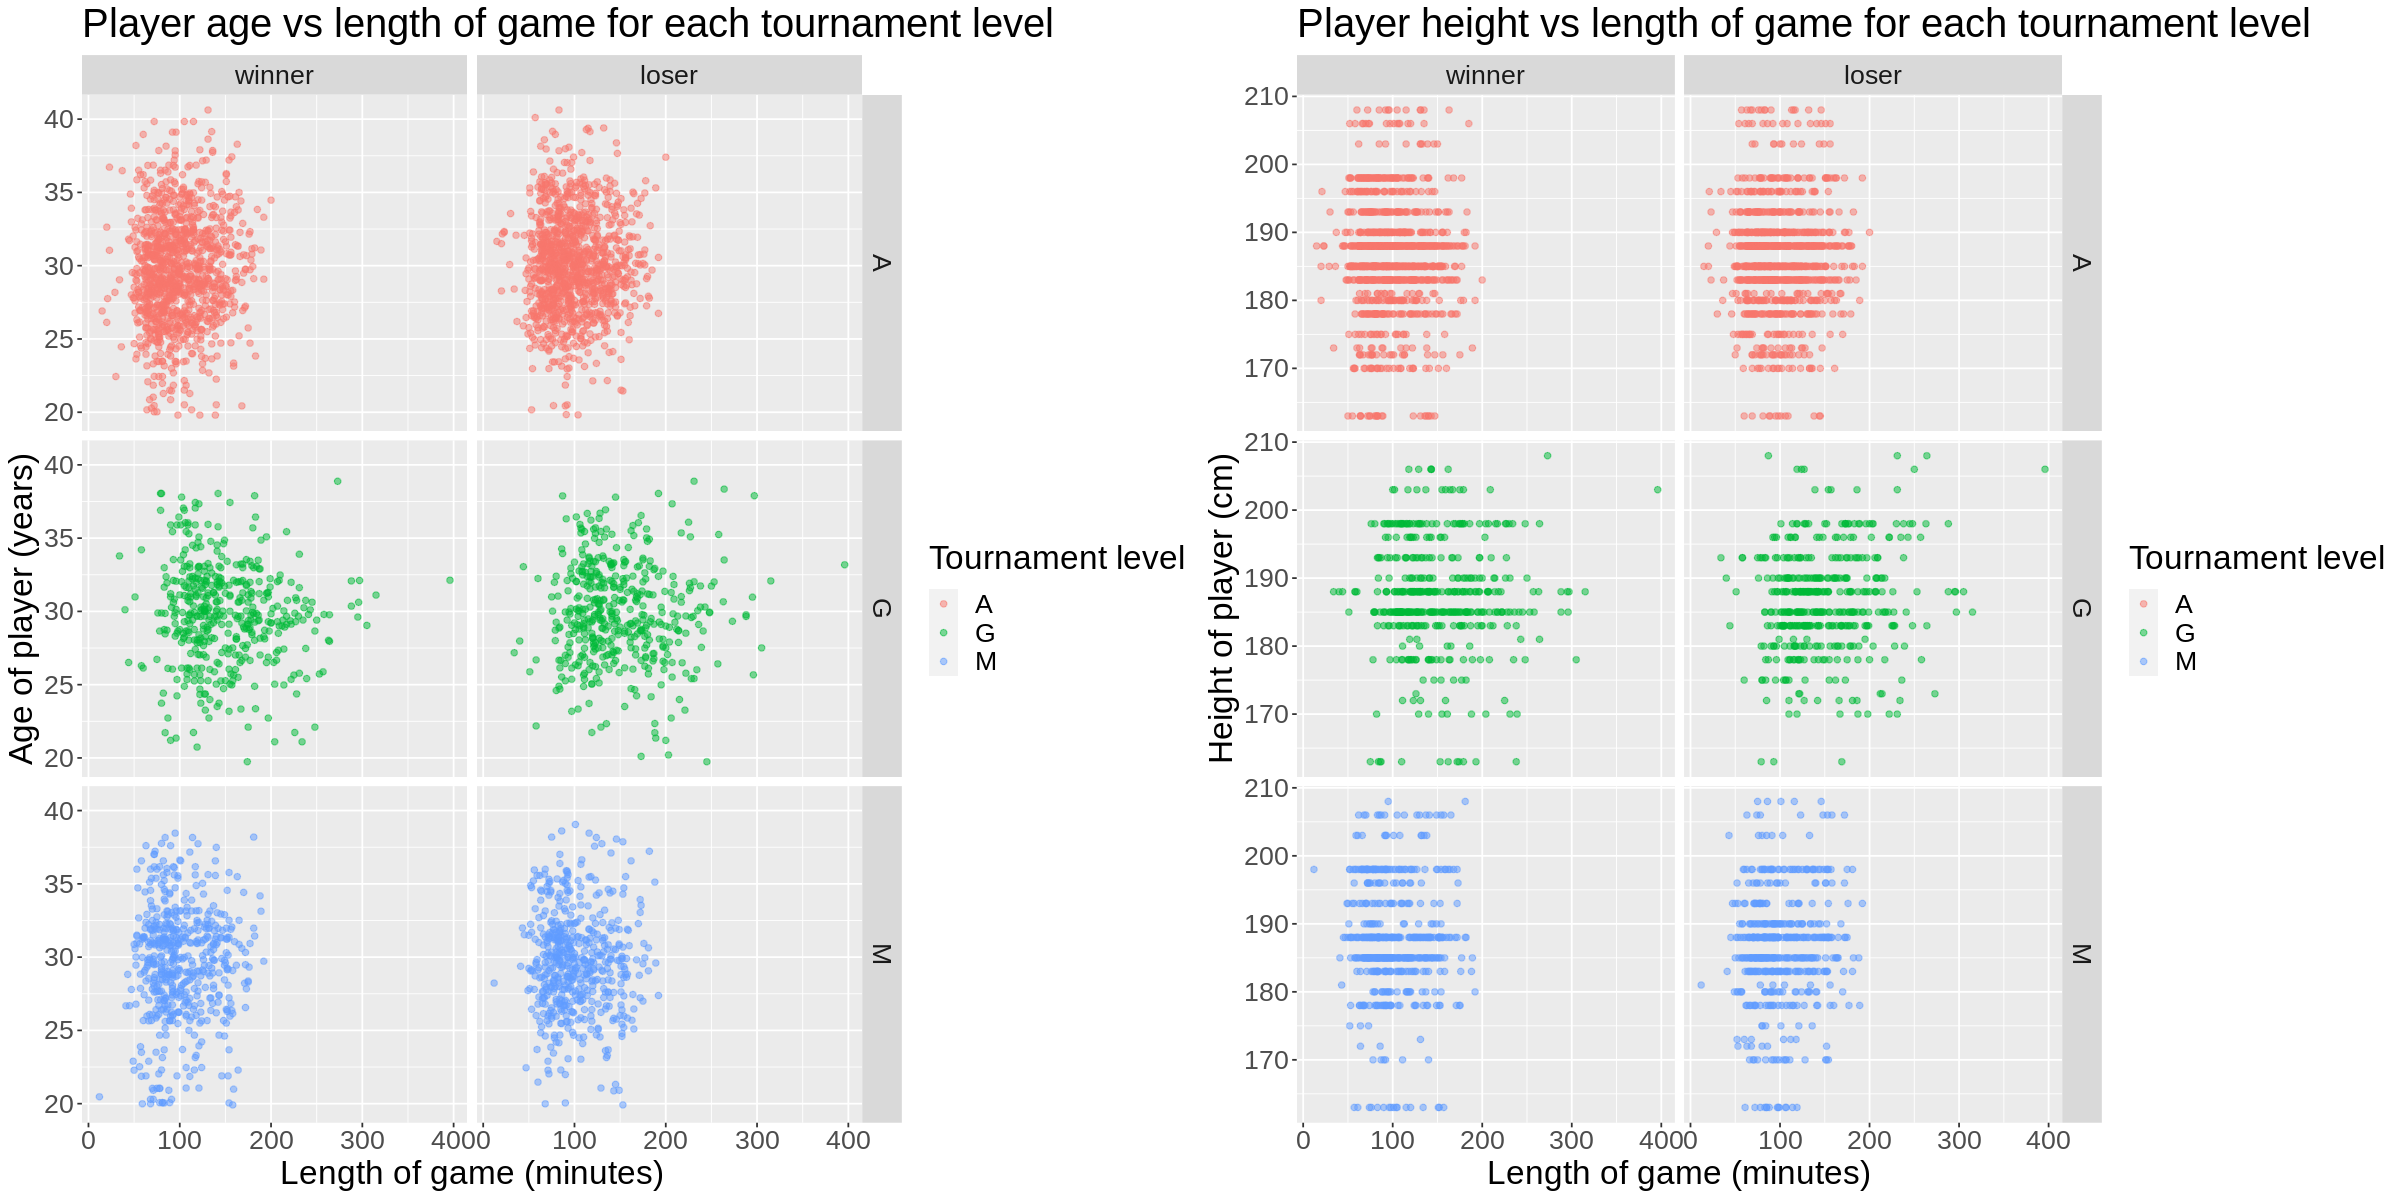

In [11]:
options(repr.plot.width = 20, repr.plot.height = 10)

# Plot the two above plots side by side (saves vertical space)
cowplot::plot_grid(tennis_plot_age, tennis_plot_height)

## Analysis

### Creating the recipe

First, we need to create the recipe that will organize and perform the necessary operations on our dataset. Since the classification algorithm we chose to use is K-nearest neighbours, the model is highly dependent on the range and means of the predicting variables. To show that there is a drop in accuracy when we upsample the data, we create a second recipe, identical to the first, with the extra upsampling step. As outlined in the introduction, the predicting variables have varying units, which we need to scale and center so that each variable contributes equally to the weighting of the model. We assign this recipe to a variable called `tennis_recipe`.

In [30]:
# Create the recipe from the training data. Scale and center the data (since we are using KNN)

tennis_recipe <- recipe(tourney_level ~ ., data = tennis_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

tennis_recipe_upsampled <- recipe(tourney_level ~ ., data = tennis_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(tourney_level)

tennis_recipe
tennis_recipe_upsampled

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()
Up-sampling based on tourney_level

### Finding the best K value by tuning the model 

After we have scaled our data appropriately, we need to determine the best value for K. As seen below, we create our model specification and add it to the workflow alongside our recipe containing the scaled data. Since we want to evaluate which K performs the best, we need a validation set to test against and to be fairly confident in the K we choose. To do this, we cross-validate by creating 5 folds of our training data. As stated before, we try 15 values of K, from 1 to 15, evaluate the model for each of these values of K, and then collect the metrics for all the models. The exact same procedure is done for the upsampled model. We assign these metrics to a variable called `knn_results`.

In [31]:
# Create folds to cross-validate our model while we tune it.

tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = tourney_level)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

knn_results <- workflow() %>%
      add_recipe(tennis_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = tennis_vfold, grid = 20) %>%
      collect_metrics(.)

knn_results_upsampled <- workflow() %>%
      add_recipe(tennis_recipe_upsampled) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = tennis_vfold, grid = 20) %>%
      collect_metrics(.)

head(knn_results)
head(knn_results_upsampled)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.4775694,5,0.008672323,Model01
2,roc_auc,hand_till,0.6070612,5,0.006689876,Model01
3,accuracy,multiclass,0.5036121,5,0.003867244,Model02
3,roc_auc,hand_till,0.6322532,5,0.007410718,Model02
4,accuracy,multiclass,0.5219347,5,0.006163264,Model03
4,roc_auc,hand_till,0.6459974,5,0.004039751,Model03


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4819114,5,0.006001786,Model01
1,roc_auc,hand_till,0.5713449,5,0.003534374,Model01
2,accuracy,multiclass,0.4819114,5,0.006001786,Model02
2,roc_auc,hand_till,0.6034530,5,0.005121472,Model02
4,accuracy,multiclass,0.4636225,5,0.008808105,Model03
4,roc_auc,hand_till,0.6299901,5,0.008162396,Model03


### Plotting the accuracies versus K

The previous step provided us with a table containing the metrics from the tuning procedure, however this is not a very intuitive way of determining the best value of K. Instead, we can filter the accuracy values from the previous table and plot them on a line graph. Again, the same procedure is done for the upsampled data. We can now compare the original data to the upsampled data, and we see that the original data results in a model that performs much better. We can now look at the original data plot to find  that we get the highest cross-validation accuracy value at K = 15.

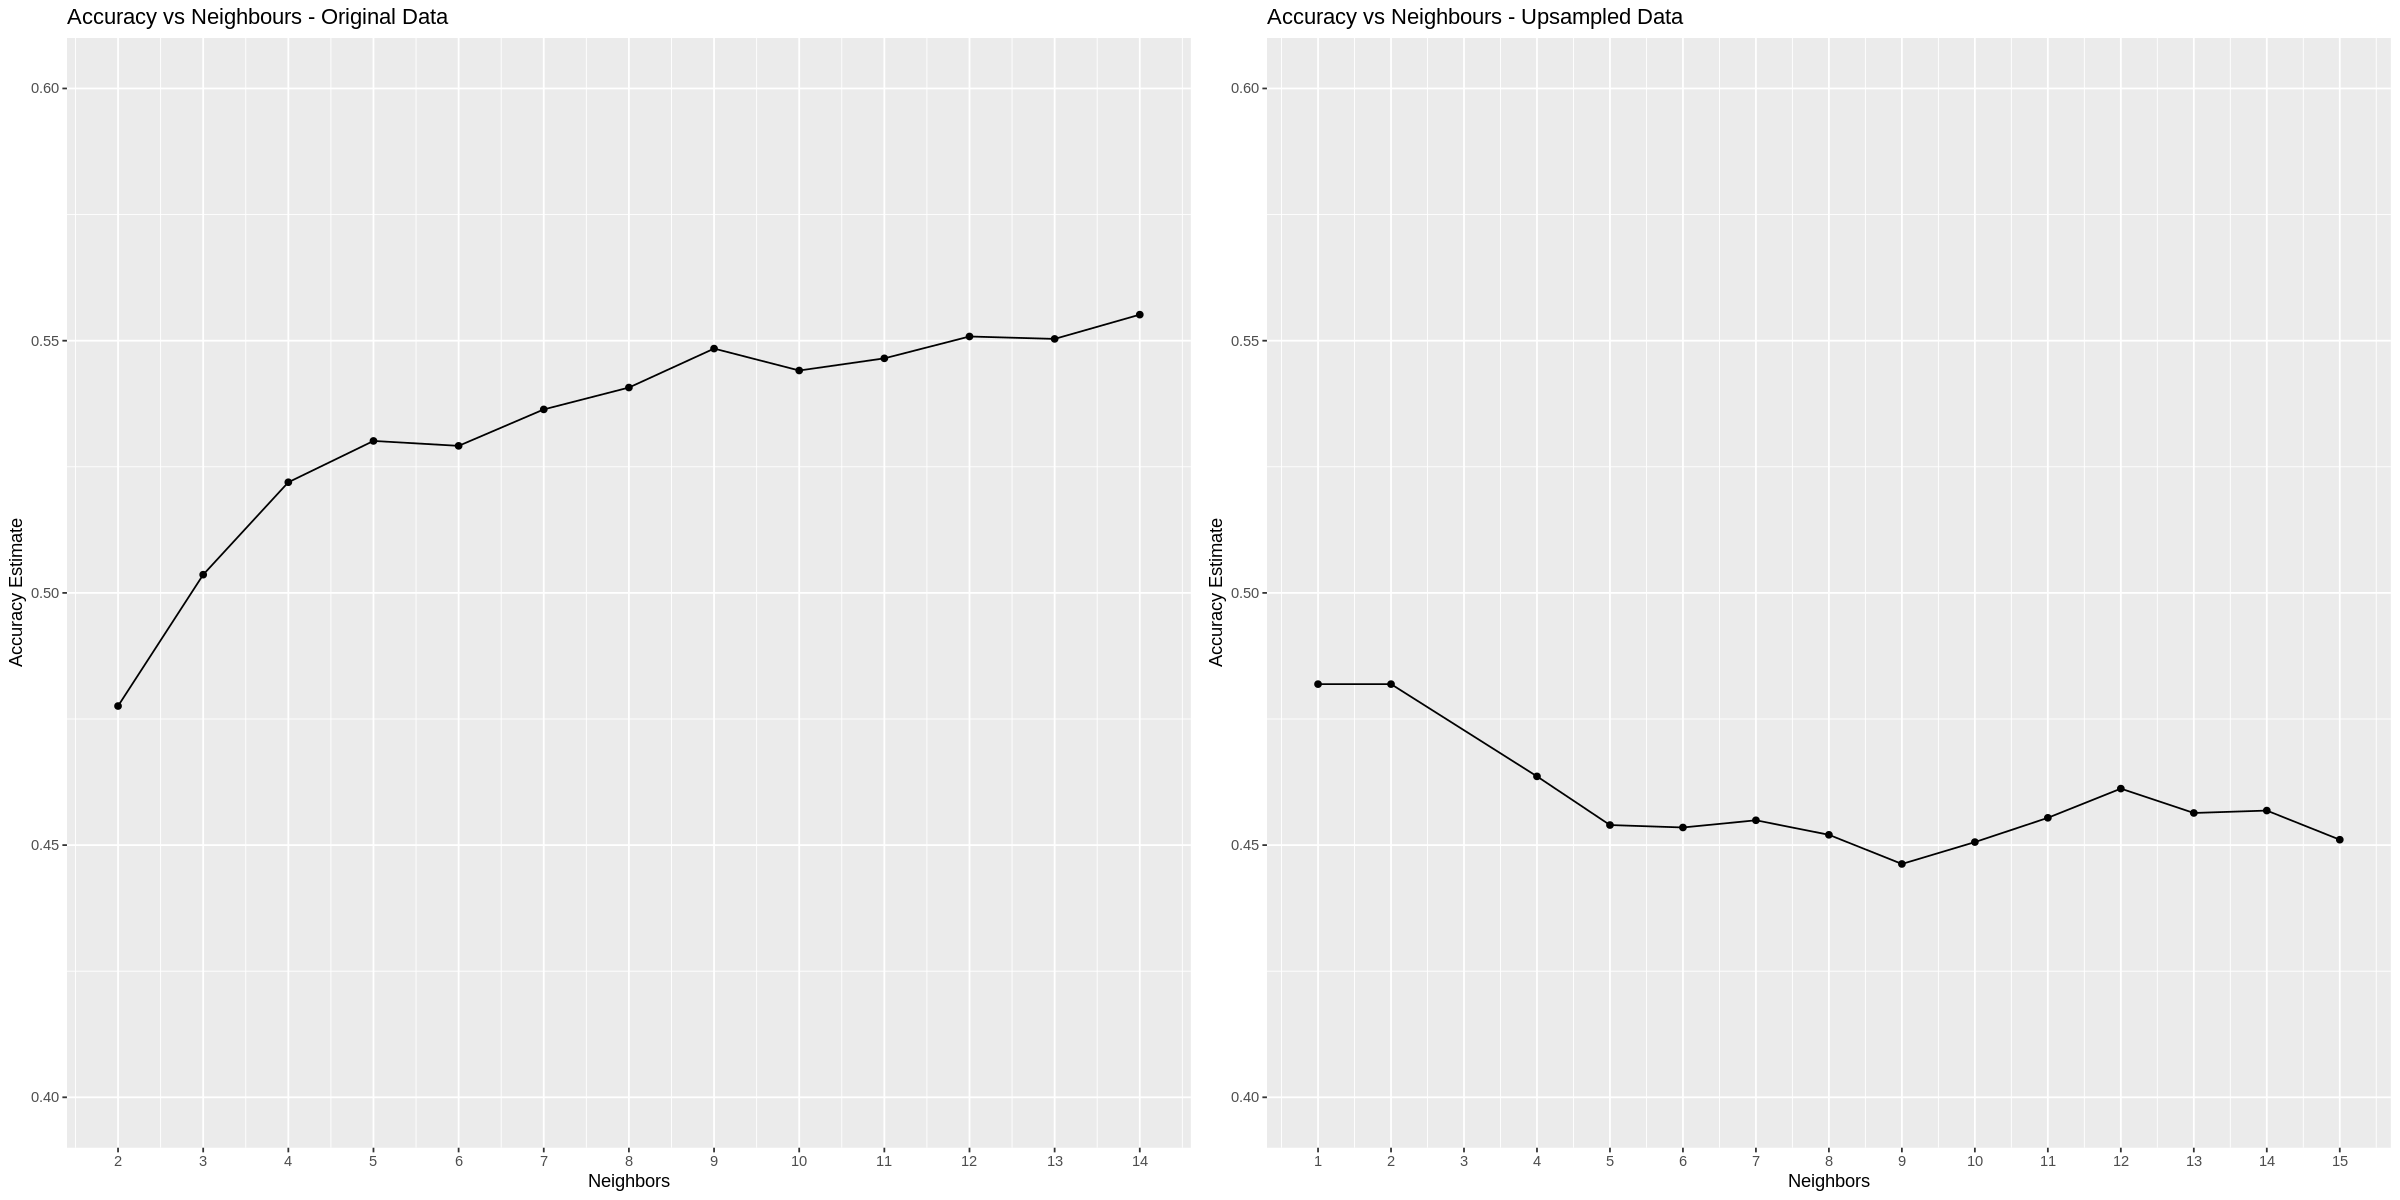

In [34]:
# Calculate and plot the accuracy of the model versus the number of neighbours (K).

accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

accuracies_upsampled <- knn_results_upsampled %>% 
      filter(.metric == "accuracy")


accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighbours - Original Data") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 0.6)) # adjusting the y-axis


accuracy_versus_k_upsampled <- ggplot(accuracies_upsampled, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs Neighbours - Upsampled Data") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 0.6)) # adjusting the y-axis

cowplot::plot_grid(accuracy_versus_k, accuracy_versus_k_upsampled)

### Fitting the final model

We now know the value of K that provides the best accuracy on our dataset, meaning we can create a new model specification with that K value. Similar to before, we create a workflow for our model, attaching the recipe (containing the original data)  and the newly created model specification. We then fit the data to create our trained model.

In [14]:
# Set K to the value with the highest accuracy, create the model specification and fit the data.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
      set_engine("kknn") %>%
      set_mode("classification")

tennis_fit <- workflow() %>%
      add_recipe(tennis_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = tennis_train)

tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~15, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.44
Best kernel: rectangular
Best k: 15

### Predicting on training dataset

We let the final model predict a tournament level for every row in the testing dataset.

In [15]:
# Run the model on the testing data set.

tennis_test_predictions <- predict(tennis_fit, tennis_test) %>%
      bind_cols(tennis_test)

head(tennis_test_predictions)

.pred_class,tourney_level,winner_ht,loser_ht,winner_age,loser_age,match_length
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A,A,188,193,31.88227,23.67967,99
A,A,188,183,27.62765,29.54689,88
A,A,188,185,31.61123,26.85284,116
A,A,188,172,31.61123,26.61465,55
A,A,185,188,26.85284,30.95414,98
A,A,203,208,32.62149,39.83847,164


## Visualizing the results

### Accuracy Value

We then calculate the accuracy of our final model by comparing the model’s prediction for every row with the true value

In [16]:
# Calculate the accuracy values from the above predictions.

tennis_prediction_accuracy <- tennis_test_predictions %>%
        metrics(truth = tourney_level, estimate = .pred_class)   
tennis_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5542692
kap,multiclass,0.1706201


### Confusion Matrix 

Similarly, we can calculate a confusion matrix to see where the model made its mistakes. We see below that the model incorrectly predicts many observations as ‘A’s, which may be due to the abundance of ‘A’s in the training dataset.

In [17]:
# Calculate the confusion matrix from the above predictions.

tennis_mat <- tennis_test_predictions %>% 
      conf_mat(truth = tourney_level, estimate = .pred_class)
tennis_mat

          Truth
Prediction   A   G   M
         A 308  82 141
         G  27  54  13
         M  33  12  21

## Discussion

After conducting the analysis, we found that the results differ substantially from what we expected. We found that we are unable to accurately predict the tournament level based on the players’ age, height, and the length of the game. We were only able to get around a 55% prediction accuracy (only slightly better than chance) as seen in the accuracy table, and the confusion matrix shows that the model had trouble correctly predicting G and M level tournaments.

We can get some insight as to why our model failed to predict the data by looking at the initial visualization (player age vs. length & player height vs. length). There is not a lot of variance between the three levels. Tournament levels A and M are very similar, and G is slightly more spread out. This provides an explanation as to why the model was able to predict G slightly better than M. Furthermore, there are a lot more data points for the A level than the others, giving it more weight in the model. We would not have had any better results if we had chosen to upsample the data, since we would have effectively been doubling the other levels with zeroed data, which would not help the model predict the differences. The similarities between each tournament level coupled with the tournament level number imbalances give rationale as to why the model was not able to accurately predict each level.

In going into this analysis, since most of the predictor variables are characteristics of the players, we assumed that these variables could be used to signify that there are traits more prevalent and/or suited in certain tournaments. For example, we thought we would find that an older and/or taller player is less likely to be in the higher tier tournaments than a younger and/or shorter player. If this was true, this could give players ideas as to how they’re likely to progress as they age and to what extent they’re limited by their height as it would be able to determine their future performance. However, since our model failed to reach even a moderately high level of accuracy (only slightly better than chance), we cannot determine if these traits of the players are representative of the tournament level they play in. We would need more data that is evenly distributed between the tournament levels (removing the need to do upsampling) to determine if our model would ever be able to accurately predict the tournament level of a player.  

We found that others have similarly devised models to predict factors of a tennis match. For example, Lisi and Grigoletto developed a model to predict the length of a tennis match based upon the features of the players. They found that they were able to predict the length with reasonable accuracy. The fact that they were successful in getting a model to predict accurately indicates that there is a connection between the players’ characteristics and the factors of the game. On the other hand, Kramer and Huijgen discussed the prediction of current and future tennis performance based on factors such as age, maturation and physical fitness. They found that, while there was a correlation between tennis performance and the factors they were measuring, they were unable to predict tennis performance three years later based upon the measurements. What we can deduce from these two studies is that statistics about the players in a tennis match can be used to determine factors about the game but not necessarily the players’ current and future performance. The direction of effect might be one such that the players’ characteristics affect the game’s statistics and tournament level instead of vice versa, which is what we were measuring.

From these two papers, along with the results from our analysis, it is reasonable to conclude that we cannot accurately determine the tournament level in which a player is in. One theory as to why this is, taking into consideration the limitations of our model, is that the tennis tournament levels are abstractly created; and not divided based upon the players skills. Therefore, trying to determine this arbitrary category by the players’ skills is not feasible. Another theory is that the characteristics of the players we chose have very little connection to the players’ performance and thus cannot successfully be used to predict the tournament level.

Future questions this could lead to are:
- “Are any of the players’ characteristics able to predict the tournament level of a match?“
- “Is there a correlation between a match’s length and the tournament level of the match?” 
- “Do any players’ characteristics predict their future performance?”
- “Do the characteristics of the two player affect the length of the match?”

## Bibliography
J. Sackman, tennis_atp (2015), https://github.com/JeffSackmann/tennis_atp 

F. Lisi, M. Grigoletto, Modeling and simulating durations of men’s professional tennis matches by resampling match features (2021), https://content.iospress.com/articles/journal-of-sports-analytics/jsa200455 

T. Kramer, B.C.H. Huijgen, M.T. Elferink-Gemser, C. Visscher, Prediction of Tennis Performance in Junior Elite Tennis Players (2017), https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5358024/ 